# k-Nearest Neighbor (kNN)

The **k-Nearest Neighbor Classifier's idea** is very simple: instead of finding the single closest image in the training set, we will find the top k closest images, and have them vote on the label of the test image. In particular, when $k = 1$, we recover the Nearest Neighbor classifier. Intuitively, higher values of k have a smoothing effect that makes the classifier more resistant to outliers:

![image info](img/knn.jpeg)
An example of the difference between Nearest Neighbor and a 5-Nearest Neighbor classifier, using 2-dimensional points and 3 classes (red, blue, green). The colored regions show the decision boundaries induced by the classifier with an L2 distance. The white regions show points that are ambiguously classified (i.e. class votes are tied for at least two classes). Notice that in the case of a NN classifier, outlier datapoints (e.g. green point in the middle of a cloud of blue points) create small islands of likely incorrect predictions, while the 5-NN classifier smooths over these irregularities, likely leading to better generalization on the test data (not shown). Also note that the gray regions in the 5-NN image are caused by ties in the votes among the nearest neighbors (e.g. 2 neighbors are red, next two neighbors are blue, last neighbor is green).


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [20]:
# Run some setup code for this notebook. Ignore this kernel!

import random
import numpy as np
from cviuh.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cviuh/datasets/cifar-10-batches-py' # change location if you upload into Colab

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


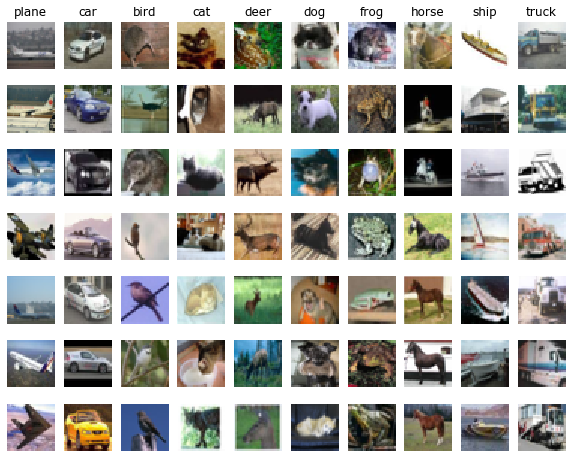

In [22]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [23]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [24]:
from cviuh.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cviuh/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [14]:
# Use cviuh/classifiers/k_nearest_neighbor.py to compute_distances_two_loops, 
# compute_distances_one_loops, or compute_distances_no_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


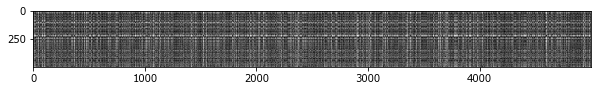

In [9]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

In [10]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27.4%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [12]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance (`27.8%`) than with `k = 1` (`27.4%`).

In [16]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [18]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [19]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 42.689498 seconds
One loop version took 82.094935 seconds
No loop version took 0.541687 seconds


# Cross-validation

In cases where the size of your training data (and therefore also the validation data) might be small, people sometimes use a more sophisticated technique for **hyperparameter tuning called cross-validation**. Working with our previous example, the idea is that instead of arbitrarily picking the first 1000 datapoints to be the validation set and rest training set, you can get a better and less noisy estimate of how well a certain value of k works by iterating over different validation sets and averaging the performance across these. For example, in **5-fold cross-validation**, we would split the training data into 5 equal folds, **use 4 of them for training, and 1 for validation**. We would then iterate over which fold is the validation fold, evaluate the performance, and finally average the performance across the different folds.

![image info](img/crossval.jpeg)
Common data splits. A training and test set is given. The training set is split into folds (for example 5 folds here). The folds 1-4 become the training set. One fold (e.g. fold 5 here in yellow) is denoted as the Validation fold and is used to tune the hyperparameters. Cross-validation goes a step further and iterates over the choice of which fold is the validation fold, separately from 1-5. This would be referred to as 5-fold cross-validation. In the very end once the model is trained and all the best hyperparameters were determined, the model is evaluated a single time on the test data (red).

We have implemented the k-Nearest Neighbor classifier but we set the value $k = 5$ arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [76]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k in k_choices:
  k_to_accuracies[k] = []

  # Test-fold index changes over iterations
  for test_idx in range(num_folds): 
    X_test_cross = X_train_folds[test_idx]
    y_test_cross = y_train_folds[test_idx]

    # Merge all 'X' train folds into one part which didn't contain the current
    # test fold.
    X_train_cross = [x for i, x in enumerate(X_train_folds) if i != test_idx]
    X_train_cross = np.concatenate(X_train_cross)

    # Merge all 'y' train folds into one part which didn't contain the current
    # test fold.
    y_train_cross = [x for i, x in enumerate(y_train_folds) if i != test_idx]
    y_train_cross = np.concatenate(y_train_cross)

    classifier.train(X_train_cross, y_train_cross)

    dists = classifier.compute_distances_no_loops(X_test_cross)

    y_test_pred = classifier.predict_labels(dists, k)
    num_correct = np.sum(y_test_pred == y_test_cross)
    accuracy = float(num_correct) / num_test

    k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.526000
k = 1, accuracy = 0.514000
k = 1, accuracy = 0.528000
k = 1, accuracy = 0.556000
k = 1, accuracy = 0.532000
k = 3, accuracy = 0.478000
k = 3, accuracy = 0.498000
k = 3, accuracy = 0.480000
k = 3, accuracy = 0.532000
k = 3, accuracy = 0.508000
k = 5, accuracy = 0.496000
k = 5, accuracy = 0.532000
k = 5, accuracy = 0.560000
k = 5, accuracy = 0.584000
k = 5, accuracy = 0.560000
k = 8, accuracy = 0.524000
k = 8, accuracy = 0.564000
k = 8, accuracy = 0.546000
k = 8, accuracy = 0.580000
k = 8, accuracy = 0.546000
k = 10, accuracy = 0.530000
k = 10, accuracy = 0.592000
k = 10, accuracy = 0.552000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.560000
k = 12, accuracy = 0.520000
k = 12, accuracy = 0.590000
k = 12, accuracy = 0.558000
k = 12, accuracy = 0.566000
k = 12, accuracy = 0.560000
k = 15, accuracy = 0.504000
k = 15, accuracy = 0.578000
k = 15, accuracy = 0.556000
k = 15, accuracy = 0.564000
k = 15, accuracy = 0.548000
k = 20, accuracy = 0.540000
k = 20, accu

In [77]:
# Cell added by me, to choose the best K value.
best_k = k_choices[0]
best_accuracy = 0

for k in sorted(k_to_accuracies):
    sum_cross = 0
    for accuracy in k_to_accuracies[k]:
        sum_cross += accuracy

    average_accuracy = sum_cross / num_folds

    if average_accuracy > best_accuracy:
      best_k = k
      best_accuracy = average_accuracy

print('Best value for k is %d (accuracy = %f)' % (best_k, best_accuracy))

Best value for k is 10 (accuracy = 0.560400)


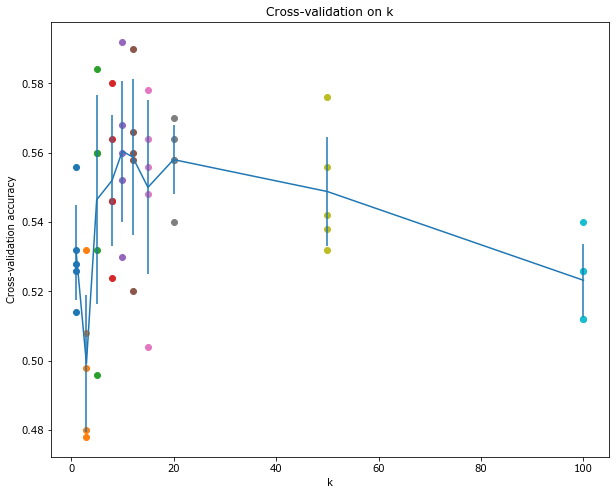

In [78]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [79]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10 # Modified value.

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


Example of a 5-fold cross-validation run for the parameter $k$. For each value of $k$ we train on 4 folds and evaluate on the 5th. Hence, for each k we receive 5 accuracies on the validation fold (accuracy is the y-axis, each result is a point). The trend line is drawn through the average of the results for each $k$ and the error bars indicate the standard deviation. Note that in this particular case, the cross-validation suggests that a value of about $k = 10$ works best on this particular dataset (corresponding to the peak in the plot). If we used more than 5 folds, we might expect to see a smoother (i.e. less noisy) curve.

## Question?

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Answer:}$ Statement that is true about kNN setting is: 4 (classification time is related to the training set).


$\color{blue}{\textit Explanation:}$

- For the statement 1: Basing on its definition, the training procedure of a kNN classifier consists on saving the training set samples. So, it’s clear that we can’t talk about a “linear classifier”.

- For the statement 2 and 3: The K value is an hyperparameter, hence, it depends on the problem nature (so, in this case, the dataset) itself. Raising the K value won’t guarantee getting a high accuracy and/or low error on the train/test set.

- For the statement 4: In order to classify a test image, kNN have to compute the distances between this image and all the training images (and after that, making a vote based on top-K distance image labels). So, the time needed to compute all the distances depends on the of training set.

# Pros and Cons of Nearest Neighbor classifier.

<ul> 
    <li> Clearly, one advantage is that it is very simple to implement and understand. </li> 
    <li> Additionally, the classifier takes no time to train, since all that is required is to store and possibly index the training data. </li>
    <li> However, we pay that computational cost at test time, since classifying a test example requires a comparison to every single training example. This is backwards, since in practice we often care about the test time efficiency much more than the efficiency at training time. </li>
    <li> In fact, the deep neural networks we will develop later in this class shift this tradeoff to the other extreme: They are very expensive to train, but once the training is finished it is very cheap to classify a new test example. This mode of operation is much more desirable in practice. </li>
</ul>
   

![image info](img/samenorm.png)
Pixel-based distances on high-dimensional data (and images especially) can be very unintuitive. An original image (left) and three other images next to it that are all equally far away from it based on L2 pixel distance. Clearly, the pixel-wise distance does not correspond at all to perceptual or semantic similarity.

## Summary: Applying kNN in Image Classification
If you wish to apply kNN in practice (hopefully not on images, or perhaps as only a baseline) proceed as follows:
<ol>
  <p>Preprocess your data: Normalize the features in your data (e.g. one pixel in images) to have zero mean and unit variance. We will cover this in more detail in later sections, and chose not to cover data normalization in this section because pixels in images are usually homogeneous and do not exhibit widely different distributions, alleviating the need for data normalization.</p>
  <li>If your data is very high-dimensional, consider using a dimensionality reduction technique such as PCA (wiki ref, CS229ref, blog ref), NCA (wiki ref, blog ref), or even Random Projections.</li>
  <p>Split your training data randomly into train/val splits. As a rule of thumb, between 70-90% of your data usually goes to the train split. This setting depends on how many hyperparameters you have and how much of an influence you expect them to have. If there are many hyperparameters to estimate, you should err on the side of having larger validation set to estimate them effectively. If you are concerned about the size of your validation data, it is best to split the training data into folds and perform cross-validation. If you can afford the computational budget it is always safer to go with cross-validation (the more folds the better, but more expensive).</p>
  <li>Train and evaluate the kNN classifier on the validation data (for all folds, if doing cross-validation) for many choices of k (e.g. the more the better) and across different distance types (L1 and L2 are good candidates).</li>
    <li> If your kNN classifier is running too long, consider using an Approximate Nearest Neighbor library (e.g. FLANN) to accelerate the retrieval (at cost of some accuracy). </li>
    <li> Take note of the hyperparameters that gave the best results. There is a question of whether you should use the full training set with the best hyperparameters, since the optimal hyperparameters might change if you were to fold the validation data into your training set (since the size of the data would be larger). In practice it is cleaner to not use the validation data in the final classifier and consider it to be burned on estimating the hyperparameters. Evaluate the best model on the test set. Report the test set accuracy and declare the result to be the performance of the kNN classifier on your data. </li>
</ol>